# Clustering Hong Kong's neighborhoods
### *Find your next apartment in similar yet cheaper locations*
-------




##### Introduction

Hong Kong is home to people from more than a hundred countries. Because of Hong Kong's status as an international financial center with offices from many multinational corporations, it has a highly transient population of expat workers who are often blindsided by a city that defies most of its portrayals in media. One common issue is the relative absence of English as a medium of communication in comparison to an apparently similar city like Singapore. Not knowing Cantonese or Mandarin can cause quite a few difficulties in daily life; foremost among these is finding the right apartment in the right neighborhood.

Choosing a suitable neighborhood depends on varied factors including age and family status. In this project, we aim to characterize Hong Kong's neighborhoods based on the types of businesses and amenities that are situated in those neighborhoods. We will then use this data to perform K-means clustering on the neighborhoods and come up with two useful widgets that identify similar neighborhoods with cheaper rents than a given one.

In [1]:
import pandas as pd
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import folium
import numpy as np
from geopy.geocoders import Nominatim
from sklearn.cluster import KMeans

Since the geopy module doesn't always successfully return the request, this function keeps making the location request recursively until it returns the result successfully.

In [2]:
from geopy.exc import GeocoderTimedOut

def do_geocode(particularaddress):
    try:
        geolocator = Nominatim(user_agent="hongkongmover", timeout=5)
        return geolocator.geocode(str(neigh)+',Hong Kong')
    except GeocoderTimedOut:
        return do_geocode(particularaddress)

We read in an Excel file (that we downloaded from a property listing website, [Spacious](https://www.spacious.hk/en/hong-kong)) which contains the names of neighborhoods, the districts in which they're located, and the average rents (in HKD) in those neighborhoods. Then, we use the function defined above to get the coordinates for every neighborhood and arrange the data in a dataframe 'coord'.

*Note: Getting the locations takes a few minutes. I've saved the dataset with the coordinates (coordi.csv) so you can skip the next few cells and read in the dataset with the coordinates directly if you want to save time.*

In [3]:
neighbor_list=pd.read_excel('neighborhoods.xlsx')

In [7]:
neighbor_list.head(3)

,Neighborhood,District,Rent per square foot
0,Kennedy Town,Central and Western,63
1,Shek Tong Tsui,Central and Western,62
2,Sai Ying Pun,Central and Western,69


In [4]:
lis=[]
for neigh in neighbor_list['Neighborhood']:
    location = do_geocode(str(neigh)+',Hong Kong')
    district=neighbor_list.loc[neighbor_list['Neighborhood']==neigh, 'District']
    if location != None:
        lis.append([district, neigh, location.raw['lat'], location.raw['lon']])
    else:
#we assign Tsim Sha Tsui's (downtown HK) coordinates as a placeholder to any neighborhood whose coordinates aren't found by Geopy
        lis.append([district, neigh, 22.2971803, 114.1722049])  
    print('.', end=' ')
                
coord=pd.DataFrame(lis)

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 

We clean up our dataframe and merge it with our original list to construct a dataframe 'result' that includes the coordinates of every neighborhood and its district. We save the data to a CSV file for future use to avoid making costly, repetitive requests to the geopy service every time we run this notebook.

In [9]:
coord.columns = ['District', 'Neighborhood', 'Latitude', 'Longitude']

coord.drop('District',axis=1,inplace=True)

result = pd.merge(coord, neighbor_list[['Neighborhood', 'District', 'Rent per square foot']] , on='Neighborhood')

result.to_csv('coordi.csv')

In [12]:
result.head(3)

,Neighborhood,Latitude,Longitude,District,Rent per square foot
0,Kennedy Town,22.2824348,114.1284168,Central and Western,63
1,Shek Tong Tsui,22.287735,114.1345987,Central and Western,62
2,Sai Ying Pun,22.286121,114.1420862,Central and Western,69


In [28]:
# Uncomment this code to read in the dataset with the coordinates directly.

#result=pd.read_csv('coordi.csv')

#result.drop('Unnamed: 0', axis=1, inplace=True)

We investigate our data and find out that Kei Ling Ha, a remote forest area, is the only neighborhood whose coordinates weren't returned by the module. We drop Kei Ling Ha from our dataset as it fails to meet any reasonable definition of a neighborhood.

In [29]:
result.loc[result['Latitude']==22.2971803, :]

,Neighborhood,Latitude,Longitude,District,Rent per square foot
32,Tsim Sha Tsui,22.29718,114.172205,Yau Tsim Mong,70
108,Kei Ling Ha,22.29718,114.172205,Tai Po,20


In [30]:
result.drop(108, axis=0, inplace=True)
result.head()

,Neighborhood,Latitude,Longitude,District,Rent per square foot
0,Kennedy Town,22.282435,114.128417,Central and Western,63
1,Shek Tong Tsui,22.287735,114.134599,Central and Western,62
2,Sai Ying Pun,22.286121,114.142086,Central and Western,69
3,Sheung Wan,22.286870,114.150267,Central and Western,57
4,Central,22.350627,114.184916,Central and Western,62


In [50]:
print('We have the coordinates and average rental cost for {} neighborhoods in {} districts.'.format(len(result['Neighborhood'].tolist()),len(result['District'].value_counts().index.tolist())))

We have the coordinates and average rental cost for 127 neighborhoods in 18 districts.


We are going to plot the neighborhood locations on a map of Hong Kong using the Folium module. Clicking on the location marker will show you the name of the neighborhood and the district.

In [315]:
# create map of Hong Kong using latitude and longitude values
map_hk = folium.Map(location=[22.345,114.17], zoom_start=11, tiles='stamenterrain')

# add markers to map
for lat, lng, neighborhood, district in zip(result['Latitude'], result['Longitude'], result['Neighborhood'], result['District']):
    lat=float(lat)
    lng=float(lng)
    label = neighborhood + ', ' + district
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=2,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_hk)  
    
map_hk

While examining the map above, I spot the markers for Central and Admiralty (Hong Kong's business districts) are at considerable distance from their real locations. So we retrieve accurate coordinates for Central and Admiralty from another online service and update our dataframe manually.

In [61]:
result.loc[result['Neighborhood']=='Central', 'Latitude']=22.281830
result.loc[result['Neighborhood']=='Central', 'Longitude']=114.158158

result.loc[result['Neighborhood']=='Admiralty', 'Latitude']=22.279119
result.loc[result['Neighborhood']=='Admiralty', 'Longitude']=114.164026

We can only analyze one variable from our dataset at the moment, rent per square foot. The histogram below shows that the distribution is skewed to the right with the median falling in the HKD40 to HKD50 range.

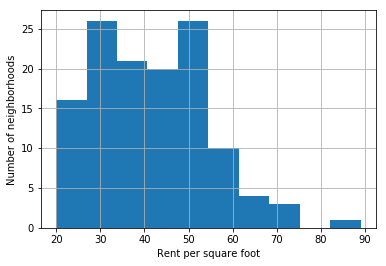

In [348]:
result['Rent per square foot'].hist()

plt.xlabel('Rent per square foot')
plt.ylabel('Number of neighborhoods')
plt.show()

-------------------
We now have a cleaned dataset that shows every neighborhood's coordinates and average rental cost. The next step will be to characterize and profile each neighborhood. This can be achieved in a multitude of ways depending on the project goal and availability of data. For this project, we will characterize each neighborhood based on the entertainment, food, and shopping options located in that neighborhood. We made this choice because the intended target of this project is the young professional (who probably has no or a young family) living in Hong Kong. This means factors like school quality, building and population density, light or sound pollution, and community engagement won't be too relevant even though they could be quite important for middle-aged and older people.

Foursquare City Guide, commonly known as Foursquare, is a local search-and-discovery service which provides recommendations of places to go near a user's current location. We will use the FourSquare API to get information on different businesses in every neighborhood.

-----

In [63]:
CLIENT_ID = 'M2YDVSOP0RR5HQWUAQLDUYJXXNJ13PGG2NWYQFP34HUY543L' # your Foursquare ID
CLIENT_SECRET = 'GJ5K3C1RAB0B03NVP53I32BTY4YEQ52GTWUWAZ2BQJKKXF0H' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentials:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentials:
CLIENT_ID: M2YDVSOP0RR5HQWUAQLDUYJXXNJ13PGG2NWYQFP34HUY543L
CLIENT_SECRET:GJ5K3C1RAB0B03NVP53I32BTY4YEQ52GTWUWAZ2BQJKKXF0H


In [66]:
import json
from pandas.io.json import json_normalize
import requests

In [84]:
# The following function returns the category of every venue returned by the FourSquare API.
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

    
def getNearbyVenues(names, districts, latitudes, longitudes, radius=500, LIMIT=100):
    
    venues_list=[]
    for name, district, lat, lng in zip(names, districts, latitudes, longitudes):
        print(name, district)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT) # We set an upper limit of 100 venues for each neighborhood.
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
         # return only relevant information for each nearby venue
        venues_list.append([(
            name,
            district,
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood',
                  'District',
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

The dataframe 'hongkong_venues' holds the data returned by the FourSquare API.

In [68]:
hongkong_venues = getNearbyVenues(names=result['Neighborhood'],
                                  districts=result['District'],
                                   latitudes=result['Latitude'],
                                   longitudes=result['Longitude']
                                  )

Kennedy Town Central and Western
Shek Tong Tsui Central and Western
Sai Ying Pun Central and Western
Sheung Wan Central and Western
Central Central and Western
Admiralty Central and Western
Mid-levels Central and Western
Peak Central and Western
Wan Chai Wan Chai
Causeway Bay Wan Chai
Happy Valley Wan Chai
Tai Hang Wan Chai
So Kon Po Wan Chai
Jardine’s Lookout Wan Chai
Tin Hau Eastern
Braemar Hill Eastern
North Point Eastern
Quarry Bay Eastern
Sai Wan Ho Eastern
Shau Kei Wan Eastern
Chai Wan Eastern
Siu Sai Wan Eastern
Pok Fu Lam Southern
Aberdeen Southern
Ap Lei Chau Southern
Wong Chuk Hang Southern
Shouson Hill Southern
Repulse Bay Southern
Chung Hom Kok Southern
Stanley Southern
Tai Tam Southern
Shek O Southern
Tsim Sha Tsui Yau Tsim Mong
Yau Ma Tei Yau Tsim Mong
West Kowloon Reclamation Yau Tsim Mong
King’s Park Yau Tsim Mong
Mong Kok Yau Tsim Mong
Tai Kok Tsui Yau Tsim Mong
Mei Foo Sham Shui Po
Lai Chi Kok Sham Shui Po
Cheung Sha Wan Sham Shui Po
Sham Shui Po Sham Shui Po
Shek Kip

In [73]:
hongkong_venues.to_csv('foursq_data.csv')

In [78]:
# In case the request to the Foursquare API doesn't go through successfully, you can read in a saved copy of the same dataset
# by uncommenting the following code.

#hongkong_venues=pd.read_csv('foursq_data.csv')
#hongkong_venues.drop('Unnamed: 0', axis=1, inplace=True)


Let's examine the data returned by Foursquare:




In [79]:
hongkong_venues.head(3)

,Neighborhood,District,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Kennedy Town,Central and Western,22.282435,114.128417,Little Creatures,22.283950,114.128264,Gastropub
1,Kennedy Town,Central and Western,22.282435,114.128417,Winstons Coffee,22.281374,114.127172,Coffee Shop
2,Kennedy Town,Central and Western,22.282435,114.128417,Catch.,22.283152,114.126988,Breakfast Spot


In [90]:
print('There are {} unique categories for the venues.'.format(len(hongkong_venues['Venue Category'].unique())))

There are 257 unique categories for the venues.


In [80]:
hongkong_venues.shape

(3034, 8)

In [83]:
len(hongkong_venues['Neighborhood'].value_counts())

122

We can see that our dataframe 'hongkong_venues' includes the name of the venue, its coordinates, and its category/type along with information on the neighborhood in which it is located. The FourSquare API returned a total of 3034 venues for 122 neighborhoods.

In the histogram below, we can see that the Foursquare data returned less than 10 venues for around 40 neighborhoods. While this probably indicates that these neighborhoods are secluded and residential, it could also suggest that more data is needed. This can be focused on in future iterations of this project. Also, there are 5 neighborhoods for which no results (i.e. venues) were returned from FourSquare. These neighborhoods have accordingly not been included in the following analysis.

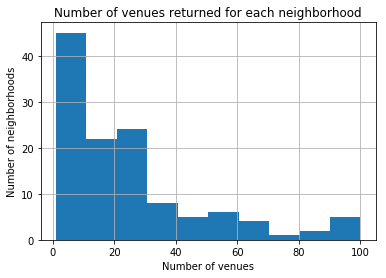

In [87]:
hongkong_venues.groupby('Neighborhood').count().sort_values('Venue').Venue.hist()

plt.title('Number of venues returned for each neighborhood')
plt.xlabel('Number of venues')
plt.ylabel('Number of neighborhoods')
plt.show()

--------------

We create indicator variables for every category:

In [95]:
# one hot encoding
hongkong_onehot = pd.get_dummies(hongkong_venues[['Venue Category']], prefix="", prefix_sep="")
hongkong_onehot.drop('Neighborhood' , axis='columns', inplace=True)
# add neighborhood column back to dataframe
hongkong_onehot.insert(0, "Neighborhood", hongkong_venues['Neighborhood'], True) 

hongkong_onehot.loc[hongkong_onehot['American Restaurant']==1, :]

#For example, we can see all the venues in the category 'American Restaurant'.

,Neighborhood,Accessories Store,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Astrologer,...,Waterfall,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Women's Store,Yoga Studio,Yunnan Restaurant,Zhejiang Restaurant,Zoo
55,Kennedy Town,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1064,Ap Lei Chau,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1165,Shek O,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1508,Tai Kok Tsui,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1660,Yau Yat Tsuen,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2267,Tsuen Wan,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2372,Lam Tei,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2625,Tai Mei Tuk,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2771,Sai Kung,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2786,Sai Kung,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Next, let's group rows by neighborhood and then standardize them to get, for every neighborhood, the proportion of venues in each category.

In [96]:
hongkong_grouped = hongkong_onehot.groupby('Neighborhood').mean().reset_index()
hongkong_grouped

,Neighborhood,Accessories Store,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Astrologer,...,Waterfall,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Women's Store,Yoga Studio,Yunnan Restaurant,Zhejiang Restaurant,Zoo
0,Aberdeen,0.000000,0.000000,0.0,0.000000,0.00,0.0,0.00,0.000000,0.000000,...,0.00,0.000000,0.0,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000
1,Admiralty,0.000000,0.000000,0.0,0.000000,0.00,0.0,0.00,0.000000,0.000000,...,0.00,0.000000,0.0,0.00,0.00,0.000000,0.018519,0.000000,0.000000,0.018519
2,Ap Lei Chau,0.000000,0.038462,0.0,0.000000,0.00,0.0,0.00,0.000000,0.000000,...,0.00,0.000000,0.0,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000
3,Beacon Hill,0.000000,0.000000,0.0,0.000000,0.00,0.0,0.00,0.000000,0.000000,...,0.00,0.000000,0.0,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000
4,Braemar Hill,0.000000,0.000000,0.0,0.000000,0.00,0.0,0.00,0.000000,0.000000,...,0.00,0.000000,0.0,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000
5,Causeway Bay,0.000000,0.000000,0.0,0.000000,0.00,0.0,0.00,0.010000,0.000000,...,0.00,0.000000,0.0,0.00,0.00,0.010000,0.010000,0.000000,0.000000,0.000000
6,Central,0.000000,0.000000,0.0,0.010000,0.01,0.0,0.00,0.010000,0.000000,...,0.00,0.000000,0.0,0.00,0.00,0.000000,0.030000,0.000000,0.000000,0.000000
7,Chai Wan,0.000000,0.000000,0.0,0.000000,0.00,0.0,0.00,0.000000,0.000000,...,0.00,0.000000,0.0,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000
8,Cheung Chau,0.000000,0.000000,0.0,0.000000,0.00,0.0,0.00,0.083333,0.000000,...,0.00,0.000000,0.0,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000
9,Cheung Muk Tau,0.000000,0.000000,0.0,0.000000,0.00,0.0,0.00,0.000000,0.000000,...,0.00,0.000000,0.0,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000


In [97]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [144]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = hongkong_grouped['Neighborhood']

for ind in np.arange(hongkong_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(hongkong_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Aberdeen,Sushi Restaurant,Athletics & Sports,Convenience Store,Shopping Mall,Bus Station
1,Admiralty,Café,Hotel,Steakhouse,Park,Cantonese Restaurant
2,Ap Lei Chau,Fast Food Restaurant,Seafood Restaurant,Shopping Mall,Chinese Restaurant,Furniture / Home Store
3,Beacon Hill,Mountain,Scenic Lookout,Fast Food Restaurant,German Restaurant,Gastropub
4,Braemar Hill,Japanese Restaurant,Taiwanese Restaurant,Ramen Restaurant,Chinese Restaurant,Zoo


In the table above, we have listed the five most popular venues for every neighborhood. This data gives us a rough idea about a neighborhood's profile.

------
We have successfully characterized each neighborhood by using the data from Foursquare. This means we can get to the most interesting part (at least for me) of the project, data modelling.

First, we're going to run the K-means clustering algorithm for a range of cluster values in order to estimate the optimal number of clusters.

K: 1    Cost: 20.592481722533492
K: 2    Cost: 19.3224477118553
K: 3    Cost: 18.18345678232718
K: 4    Cost: 17.194535139821014
K: 5    Cost: 16.51006798715752
K: 6    Cost: 15.328849619864664
K: 7    Cost: 14.41674464293395
K: 8    Cost: 13.44473217470945
K: 9    Cost: 12.94375760528336
K: 10    Cost: 11.437177505512322
K: 11    Cost: 10.7839729719109
K: 12    Cost: 10.916470034174267
K: 13    Cost: 9.91815544333233
K: 14    Cost: 9.725179563049117
K: 15    Cost: 8.979034780826389
K: 16    Cost: 8.60963151881367
K: 17    Cost: 8.07505281047543
K: 18    Cost: 7.870278167378684
K: 19    Cost: 7.689933224582633


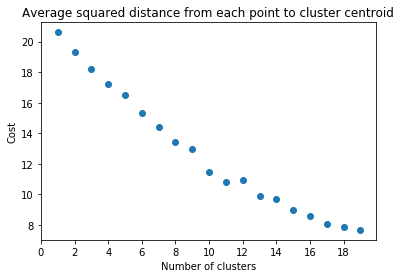

In [145]:
hongkong_grouped_clustering = hongkong_grouped.drop('Neighborhood', 1)

cost_list=[]
for k in range (1, 20):
 
        # Create a kmeans model on our data, using k clusters.  random_state helps ensure that the algorithm returns the same results each time.
        # the default parameters of the KMeans algorithms instruct the algorithm to run 10 times for each number of clusters
        # with different centroid initializations to ensure we avoid local minima
        kmeans_model = KMeans(n_clusters=k, random_state=1, max_iter=600).fit(hongkong_grouped_clustering.iloc[:, :])
 
        # These are our fitted labels for clusters -- the first cluster has label 0, and the second has label 1.
        labels = kmeans_model.labels_
        
        # Sum of distances of samples to their closest cluster center
        inertia = kmeans_model.inertia_
        print ("K:",k, "   Cost:", inertia)
        cost_list.append([k,inertia])
        
c_list=pd.DataFrame(cost_list)
c_list.columns=['k', 'cost']

plt.scatter(c_list['k'],c_list['cost'])
plt.title('Average squared distance from each point to cluster centroid')
plt.ylabel('Cost')
plt.xlabel('Number of clusters')
plt.xticks(np.arange(0, 20, step=2))
plt.show()

In order to choose the optimal number of clusters, we can use a basic heuristic called the 'elbow method' which suggests that we should pick that number of clusters beyond which there is minimal improvement (i.e. decrease) in the cost function (the average squared distance from each point to cluster centroid). This would appear as a sudden decrease in the slope of the scatter plot above (i.e. an elbow in the plot). We will opt for 10 clusters for the rest of this project.

In [146]:
# set number of clusters
kclusters = 10

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0, max_iter=600).fit(hongkong_grouped_clustering)

# check cluster labels generated for first 30 neighborhoods in the dataframe
kmeans.labels_[0:30]

array([2, 3, 2, 4, 3, 3, 3, 2, 3, 3, 2, 0, 2, 3, 2, 3, 3, 2, 3, 2, 3, 3,
       4, 2, 2, 0, 3, 3, 2, 3])

In [147]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

hongkong_merged = result  #the 'result' dataset contains the coordinates and rental cost for every neighborhood

# merge hongkong_merged with neighborhoods_venues_sorted to add latitude/longitude and price for each neighborhood
hongkong_merged = hongkong_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

hongkong_merged.fillna(10, inplace=True) #assigning cluster label '10' to the neighborhoods which didn't have any venues
hongkong_merged['Cluster Labels']=hongkong_merged['Cluster Labels'].astype('int64')
hongkong_merged.tail()

,Neighborhood,Latitude,Longitude,District,Rent per square foot,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
123,Peng Chau,22.285544,114.038250,Islands,32,3,Seafood Restaurant,Pier,Museum,Harbor / Marina,Chinese Restaurant
124,Tung Chung,22.286213,113.939913,Islands,27,3,Sporting Goods Shop,Chinese Restaurant,Clothing Store,Sushi Restaurant,Bakery
125,Discovery Bay,22.297369,114.016528,Islands,40,3,Pizza Place,Chinese Restaurant,Beach,Thai Restaurant,Plaza
126,Mui Wo,22.264545,114.001306,Islands,27,3,Seafood Restaurant,Café,Mediterranean Restaurant,Pub,Park
127,Lamma Island,22.209441,114.149767,Islands,26,3,Pier,Mediterranean Restaurant,Zoo,Fish & Chips Shop,German Restaurant


We will now plot markers for all the neighborhoods on a map of Hong Kong with each marker colored according to its assigned cluster. Clicking on a marker will show you the neighborhood's name and cluster label.

In [316]:
# create map
map_clusters = folium.Map(location=[22.343,114.165], zoom_start=11, tiles='stamenterrain')

# set color scheme for the clusters
x = np.arange(kclusters+1)
ys = [i + x + (i*x)**2 for i in range(kclusters+1)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(hongkong_merged['Latitude'], hongkong_merged['Longitude'], hongkong_merged['Neighborhood'], hongkong_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [float(lat), float(lon)],
        radius=2,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [165]:
hongkong_merged[['Neighborhood','Cluster Labels']].groupby('Cluster Labels').count()

,Neighborhood
Cluster Labels,
0,8
1,1
2,40
3,65
4,2
5,2
6,1
7,1
8,1


In the table above, we can see that clusters 2 and 3 are the most common. Some clusters have only one neighborhood which could indicate overfitting. Real-world knowledge of the dataset can assist in such a situation.

Based on my experience from living in Hong Kong for more than 6 years, I believe the clusters which include only one neighborhood are justified because of their unique locations and surroundings. Skeptical readers might wish to find on the map these unique neighborhoods to assuage any doubts.

We can now examine any cluster that interests us and determine the discriminating venue categories that distinguish that cluster. Based on the defining categories, you can come up with a general profile of the cluster.

In [214]:
hongkong_merged.loc[hongkong_merged['Cluster Labels'] == 0, hongkong_merged.columns[[0] + list(range(5, hongkong_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
18,Sai Wan Ho,0,Chinese Restaurant,Cantonese Restaurant,Indian Restaurant,Hong Kong Restaurant,Park
47,To Kwa Wan,0,Chinese Restaurant,Cha Chaan Teng,Park,Bus Stop,Steakhouse
72,Kwai Chung,0,Pool,Chinese Restaurant,Market,Asian Restaurant,Zoo
78,Tsing Lung Tau,0,Chinese Restaurant,Diner,Bus Stop,Pier,Zoo
92,Kam Tin,0,Chinese Restaurant,Farm,Market,Zoo,Frozen Yogurt Shop
93,Shek Kong,0,Chinese Restaurant,Bus Station,Café,Pakistani Restaurant,Diner
99,Sha Tau Kok,0,Border Crossing,Chinese Restaurant,Zoo,Fujian Restaurant,Food & Drink Shop
115,Clear Water Bay,0,Chinese Restaurant,Italian Restaurant,Bus Station,Shanghai Restaurant,Market


The table above shows that neighborhoods in cluster 0 have a lot of Chinese restaurants. In the absence of data on neighborhood demographics, one can deduce that these neighborhoods are more popular among Hong Kong locals.

Similar analysis can be done for the other clusters as well.

In [317]:
#function for hiding a code cell

from IPython.display import HTML
import random

def hide_toggle(for_next=False):
    this_cell = """$('div.cell.code_cell.rendered.selected')"""
    next_cell = this_cell + '.next()'

    toggle_text = 'Toggle show/hide'  # text shown on toggle link
    target_cell = this_cell  # target cell to control with toggle
    js_hide_current = ''  # bit of JS to permanently hide code in current cell (only when toggling next cell)

    if for_next:
        target_cell = next_cell
        toggle_text += ' next cell'
        js_hide_current = this_cell + '.find("div.input").hide();'

    js_f_name = 'code_toggle_{}'.format(str(random.randint(1,2**64)))

    html = """
        <script>
            function {f_name}() {{
                {cell_selector}.find('div.input').toggle();
            }}

            {js_hide_current}
        </script>

        <a href="javascript:{f_name}()">{toggle_text}</a>
    """.format(
        f_name=js_f_name,
        cell_selector=target_cell,
        js_hide_current=js_hide_current, 
        toggle_text=toggle_text
    )

    return HTML(html)

hide_toggle()

-------
Now that we have characterized the neighborhoods, we can use our data in many different ways. 

One application can be to use our data to identify most similar neighborhoods. For example, you can select your neigborhood in the following code cells and we will use our data to identify the most similar neighborhood based on Euclidean distance. Such information can be useful if you want to move to another neighborhood that is similar to the one in which you reside now.

In [318]:
# Function for identifying most similar neighborhood

from scipy.spatial import distance

def simneigh(neigh_chosen, dataset):
    a = dataset.loc[dataset['Neighborhood']==neigh_chosen, :].iloc[:, 1:]
    max=100
    for item in dataset['Neighborhood']:
    
        if item==neigh_chosen:
            continue
    
        b = dataset.loc[dataset['Neighborhood']==item, :].iloc[:, 1:]
        dst = distance.euclidean(a, b)
    
        if dst < max:
            max=dst
            best=item
            
    return best

In [330]:
from ipywidgets import interactive
from IPython.display import display

def my_function(x):
    return x

dist_list=result['District'].unique().tolist()
widget = interactive(my_function, x=dist_list, description='Hey')
print('CHOOSE YOUR DISTRICT:')
display(widget)

hide_toggle()

CHOOSE YOUR DISTRICT:


interactive(children=(Dropdown(description='x', options=('Central and Western', 'Wan Chai', 'Eastern', 'Southe…

In [331]:
dist_chosen=widget.result
neigh_list = result.loc[result['District']==dist_chosen, ['Neighborhood']]['Neighborhood'].tolist()
widget = interactive(my_function, x=neigh_list)
print('CHOOSE YOUR NEIGHBORHOOD')
display(widget)

hide_toggle()

CHOOSE YOUR NEIGHBORHOOD


interactive(children=(Dropdown(description='x', options=('Pok Fu Lam', 'Aberdeen', 'Ap Lei Chau', 'Wong Chuk H…

In [332]:
neigh_chosen=widget.result

best_neigh = simneigh(neigh_chosen, hongkong_grouped)        
best_dist = result.loc[result['Neighborhood']==best_neigh, 'District'].iloc[0]

print('*****************************\n')
print('The neighborhood most similar to "{}, {}" is "{}, {}".\n'.format(neigh_chosen, dist_chosen, best_neigh, best_dist))
print('*****************************\n')

*****************************

The neighborhood most similar to "Wong Chuk Hang, Southern" is "Sheung Wan, Central and Western".

*****************************



We can also utilize our clustering model to suggest similar neighborhoods which have the cheapest average rent per square foot. Since we have two constraints (neighborhood similarity and rental cost), we will have to optimize for them one by one. The other option would be to assign weights signifying the relative importance of these two constraints but we decide not to pursue that idea because being asked to specify weights would unnecessarily complicate matters for our intended users. Upon selection of the user's current neighborhood, our code will first identify the neighborhood's cluster and then, from within that cluster, pick out the neighborhood with the cheapest rent.

In [344]:
def my_function(x):
    return x

dist_list=result['District'].unique().tolist()
widget = interactive(my_function, x=dist_list)
print('CHOOSE YOUR DISTRICT:')
display(widget)

hide_toggle()

CHOOSE YOUR DISTRICT:


interactive(children=(Dropdown(description='x', options=('Central and Western', 'Wan Chai', 'Eastern', 'Southe…

In [345]:
distr_chosen=widget.result
neigh_list = result.loc[result['District']==distr_chosen, ['Neighborhood']]['Neighborhood'].tolist()
widget = interactive(my_function, x=neigh_list)
print('CHOOSE YOUR NEIGHBORHOOD')
display(widget)

hide_toggle()

CHOOSE YOUR NEIGHBORHOOD


interactive(children=(Dropdown(description='x', options=('Tsim Sha Tsui', 'Yau Ma Tei', 'West Kowloon Reclamat…

In [346]:
neighb_chosen=widget.result

chosen_cluster = hongkong_merged.loc[hongkong_merged['Neighborhood']==neighb_chosen, 'Cluster Labels'].iloc[0]

goodopt = hongkong_merged.loc[hongkong_merged['Cluster Labels']==chosen_cluster, ['Neighborhood','District','Rent per square foot']].sort_values(by='Rent per square foot').iloc[0, :]
goodneigh=goodopt[0]
gooddist=goodopt[1]

print('*****************************\n')
print('For the chosen neighborhood {} in district {}, the cluster label is {} and the neighborhood in the same cluster with the cheapest rent per square foot is {}, {}.\n'.format(neighb_chosen, distr_chosen, chosen_cluster, goodneigh, gooddist))
print('*****************************\n')

*****************************

For the chosen neighborhood Mong Kok in district Yau Tsim Mong, the cluster label is 3 and the neighborhood in the same cluster with the cheapest rent per square foot is Wu Kau Tang, North.

*****************************

